# Settings

In [1]:
#@title imports
import os, zipfile, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers, Model

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from google.colab import files

In [ ]:
#@title downloads
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
%%capture
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
# Set the weights file into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# download zip with data
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
# extract zip content
local_zip = './cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
#@title constants
EPOCHS=100

In [ ]:
#@title functions
def plot_loss_acc(history):
  train_acc      = history.history[     'accuracy' ]
  val_acc  = history.history[ 'val_accuracy' ]
  train_loss     = history.history[    'loss' ]
  val_loss = history.history['val_loss' ]
  epochs   = range(len(train_acc))

  plt.rcParams['figure.figsize'] = [5, 2]

  # plot training and validation accuracy per epoch
  plt.subplot(1, 3, 1)
  plt.plot  ( epochs,     train_acc )
  plt.plot  ( epochs, val_acc )
  plt.title ( 'Accuracy' )

  # plot training and validation loss per epoch
  plt.subplot(1, 3, 2)
  plt.plot  ( epochs,     train_loss )
  plt.plot  ( epochs, val_loss )
  plt.title ( 'Loss' )

  # subplot for legend
  plt.subplot(1, 3, 3)
  plt.plot([], [], label='Plot 1')
  plt.plot([], [], label='Plot 2')
  plt.legend(loc='upper left')
  plt.axis('off')

  plt.tight_layout(rect=[0, 0, 2, 1])
  plt.legend(['training', 'validation'], loc='upper left')
  plt.show();

def train_val_generators(TRAINING_DIR, VALIDATION_DIR, augmentation=True):
  """create data generators which will read pictures and convert them to float32 tensors"""

  # create train_datagen with or without augmentation
  train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
  ) if augmentation else ImageDataGenerator(rescale = 1./255)

  # create train generator
  train_generator = train_datagen.flow_from_directory(
      directory=TRAINING_DIR,
      batch_size=20,
      class_mode='binary',
      target_size=(150, 150)
  )

  # create validation datagen and generator
  validation_datagen = ImageDataGenerator(rescale=1./255)
  validation_generator = validation_datagen.flow_from_directory(
      directory=VALIDATION_DIR,
      batch_size=20,
      class_mode='binary',
      target_size=(150, 150)
  )
  return train_generator, validation_generator

# Dataset

In [ ]:
#@title files and directories

base_dir = 'cats_and_dogs_filtered'
print(f"Contents of base directory: {os.listdir(base_dir)}")
print(f"Contents of train directory: {os.listdir(f'{base_dir}/train')}")
print(f"Contents of validation directory: {os.listdir(f'{base_dir}/validation')}")

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )
print('\ncat files:', train_cat_fnames[:5])
print('dog files:', train_dog_fnames[:5])
print('\ntotal training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir( validation_cats_dir)))
print('total validation dog images:', len(os.listdir( validation_dogs_dir)))

Contents of base directory: ['vectorize.py', 'validation', 'train']
Contents of train directory: ['dogs', 'cats']
Contents of validation directory: ['dogs', 'cats']

cat files: ['cat.777.jpg', 'cat.850.jpg', 'cat.545.jpg', 'cat.556.jpg', 'cat.443.jpg']
dog files: ['dog.49.jpg', 'dog.38.jpg', 'dog.218.jpg', 'dog.300.jpg', 'dog.23.jpg']

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


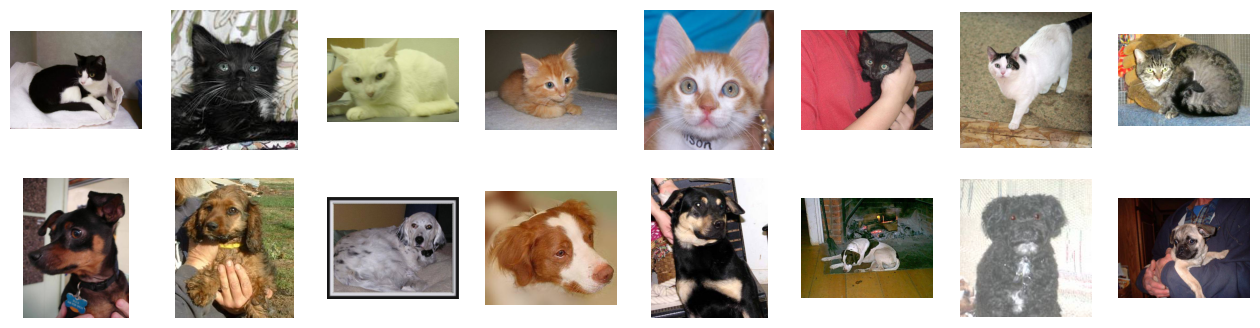

In [ ]:
#@title display random images

nrows = 2
ncols = 8

fig = plt.gcf()
fig.set_size_inches(ncols*2, nrows*2)
cat_pix = [os.path.join(train_cats_dir, fname) for fname in random.choices(train_cat_fnames, k=8)]
dog_pix = [os.path.join(train_dogs_dir, fname) for fname in random.choices(train_dog_fnames, k=8)]

for i, img_path in enumerate(cat_pix+dog_pix):
  sp = plt.subplot(nrows, ncols, i + 1) # set up subplot; subplot indices start at 1
  sp.axis('Off') # don't show axes or gridlines
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

# Model

In [ ]:
#@title define and compile the model
model = tf.keras.models.Sequential([
    # the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics = ['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

# Training without augmentation

In [ ]:
import sys
sys.exit("Execution stopped. Please run cells selectively.")

In [ ]:
#@title train model without augmentation

train_generator, validation_generator = train_val_generators(train_dir, validation_dir, augmentation=False)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=2
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


NameError: ignored

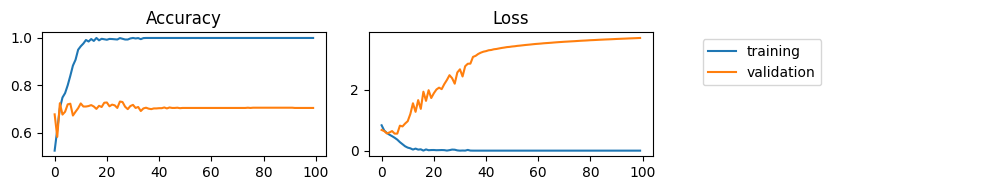

In [ ]:
#@title plot training history without augmentation
plot_loss_acc(history)

The model without augmentation is overfitting!!!
The training accuracy gets close to 100% while the validation accuracy stalls as 70%. The validation loss is stuck.  
Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions.

# Training with augmentation

In [ ]:
import sys
sys.exit("Execution stopped. Please run cells selectively.")

In [ ]:
#@title train model with augmentation

train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=2
)

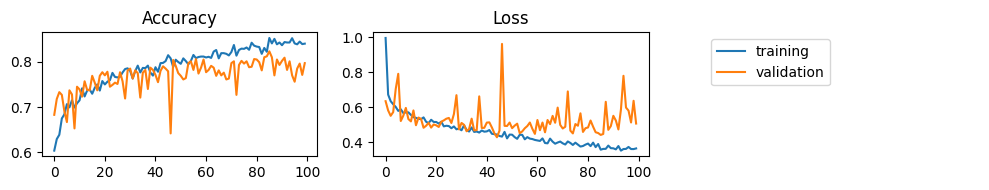

In [ ]:
#@title plot training history with augmentation
plot_loss_acc(history)

# Visualize Intermediate Representations

1/1 [==============================] - 0s 90ms/step


<ipython-input-21-819905fff444>:36: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std ()


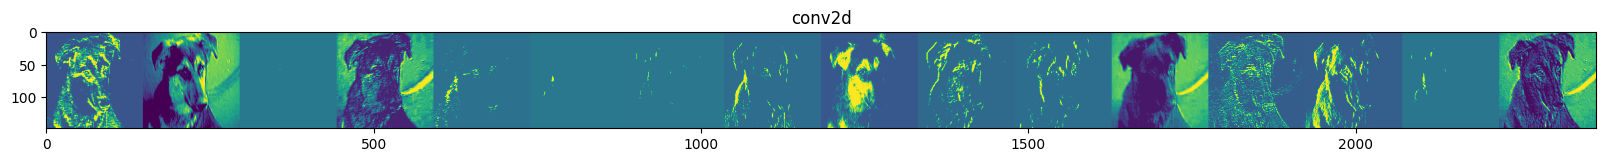

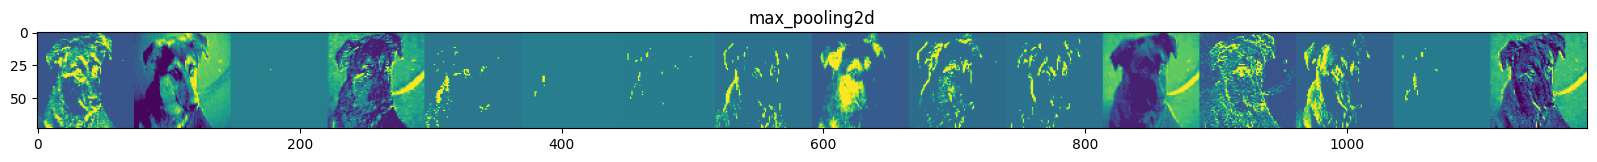

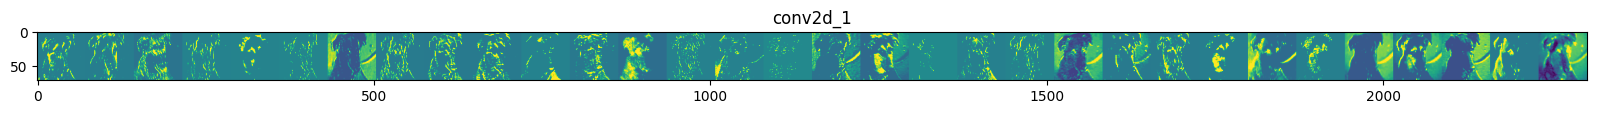

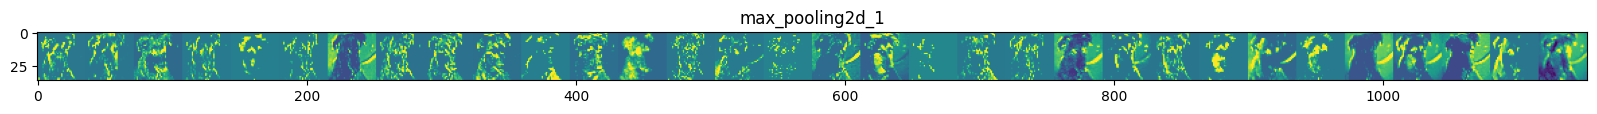

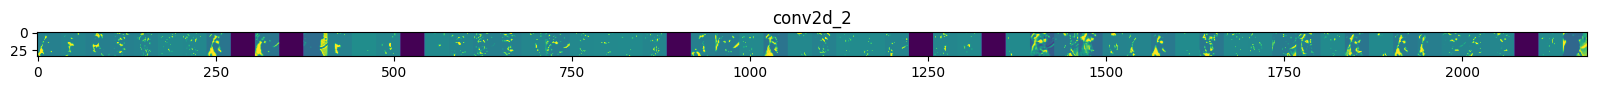

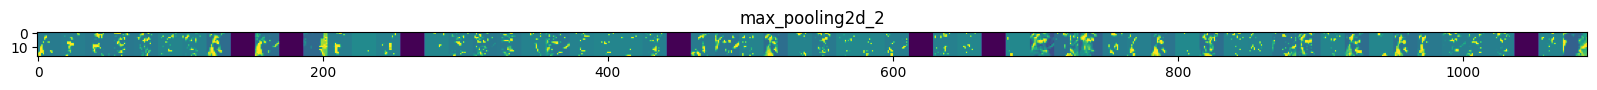

In [ ]:
#@title visualize intermediate representations

# define a new model that will take an image as input, and will output intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)
x /= 255.0                                        # Scale by 1/255

# Run the image through the network, thus obtaining all intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# Display the representations
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):

  if len(feature_map.shape) == 4:

    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))

    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    # Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

# Transfer learning

In transfer learning we take an existing model that's trained on large amount of data and use the features that model learned.

## Create pre trained model

In [ ]:
# Initialize the base model. Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False, # go straight to convolutions
                                weights = None) # don't use built-in weights

# Load the pre-trained weights from downloaded model
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers preventing already learned convolutions from re-training
for layer in pre_trained_model.layers:
  layer.trainable = False

# pre_trained_model.summary() # the model is very deep

In [ ]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
print('last layer output: ', last_output)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


## Train without dropout

In [ ]:
import sys
sys.exit("Execution stopped. Please run cells selectively.")

In [ ]:
#@title define model without dropouts

# Flatten the output from the inception model's "mixed7" layer layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Print the model summary. See your dense network connected at the end.
# model.summary() # ? still very deep

In [ ]:
#@title train model witout dropouts
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = EPOCHS,
            validation_steps = 50,
            verbose = 2)

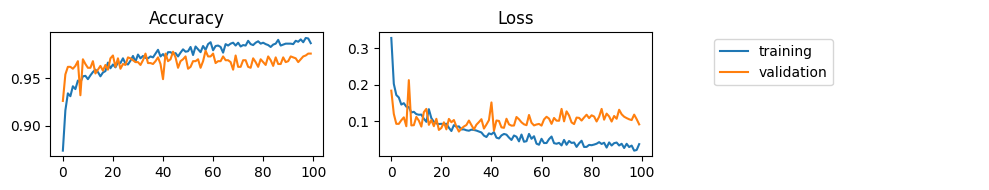

In [ ]:
#@title plot training history without dropouts
plot_loss_acc(history)

# not much overfitting in this example, usually it would be

## Train with dropout

The idea behind the droupout is that layers in a neural network can sometimes end up having similar weights and possibly impact each other leading to over-fitting (skewing the final training). It can be the case with a big complex models.  
Dropping some layers out has the effect of neighbours not affecting each other too much and potentially removing overfitting.

In [ ]:
import sys
sys.exit("Execution stopped. Please run cells selectively.")

In [ ]:
#@title define model with dropouts

# Flatten the output from the inception model's "mixed7" layer layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate 0.2 - a fraction of units to drop
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

# Print the model summary. See your dense network connected at the end.
# model.summary() # ? still very deep

In [ ]:
#@title train model with dropouts
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = EPOCHS,
            validation_steps = 50,
            verbose = 2)

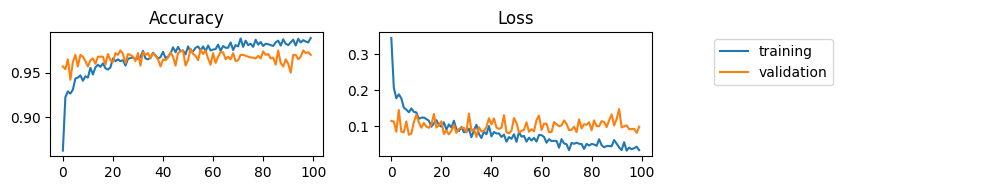

In [ ]:
#@title plot training history with dropouts
plot_loss_acc(history)

# Predict

In [ ]:
#@title predict

uploaded=files.upload()

for fn in uploaded.keys():

  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(150, 150))

  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

  print(classes[0])

  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving American_Eskimo_Dog.jpg to American_Eskimo_Dog.jpg
Saving cat-2083492_1280.jpg to cat-2083492_1280.jpg
Saving cat_glasses.jpg to cat_glasses.jpg
Saving cute-cat-photos-1593441022.jpg to cute-cat-photos-1593441022.jpg
Saving dog_1.jpeg to dog_1.jpeg
Saving dog_2.jpeg to dog_2.jpeg
1/1 [==============================] - 2s 2s/step
[0.987362]
American_Eskimo_Dog.jpg is a dog
1/1 [==============================] - 0s 25ms/step
[6.840655e-05]
cat-2083492_1280.jpg is a cat
1/1 [==============================] - 0s 25ms/step
[0.01861449]
cat_glasses.jpg is a cat
1/1 [==============================] - 0s 25ms/step
[0.00785973]
cute-cat-photos-1593441022.jpg is a cat
1/1 [==============================] - 0s 27ms/step
[1.]
dog_1.jpeg is a dog
1/1 [==============================] - 0s 29ms/step
[1.]
dog_2.jpeg is a dog
